##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multilevel Modeling Primer in TensorFlow Probability

**This example is ported from the PyMC3 example notebook
[A Primer on Bayesian Methods for Multilevel Modeling](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/multilevel_modeling.ipynb)**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### Dependencies & Prerequisites

In [ ]:
#@title Import { display-mode: "form" }


import collections
import os
from six.moves import urllib
import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

warnings.simplefilter('ignore')

## 1 Introduction

In this colab we will fit hierarchical linear models (HLMs) of various degrees
of model complexity using the popular _Radon_ dataset. We will make use of TFP
primitives and its Markov Chain Monte Carlo toolset.

To better fit the data, our goal is to make use of the natural hierarchical structure 
present in the dataset. We begin with conventional approaches: completely pooled 
and unpooled models. We continue with multilevel models: exploring partial pooling
models, group-level predictors and contextual effects.

For a related notebook also fitting HLMs using TFP on the Radon dataset, check
out
[Linear Mixed-Effect Regression in {TF Probability, R, Stan}](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb).

If you have any questions about the material here, don't hesitate to contact (or
join)
[the TensorFlow Probability mailing list](https://groups.google.com/a/tensorflow.org/forum/#!forum/tfprobability).
We're happy to help.

## 2 Multilevel Modeling Overview

### A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling.

Multilevel models are regression models in which the constituent model
parameters are given probability distributions. This implies that model parameters are allowed to vary by group. Observational units are often naturally clustered. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A hierarchical model is a particular multilevel model where parameters are
nested within one another. Some multilevel structures are not hierarchical.

e.g. "country" and "year" are not nested, but may represent separate, but
overlapping, clusters of parameters We will motivate this topic using an
environmental epidemiology example.

**Example: Radon contamination (Gelman and Hill 2006)**

Radon is a radioactive gas that enters homes through contact points with the
ground. It is a carcinogen that is the primary cause of lung cancer in
non-smokers. Radon levels vary greatly from household to household.

The EPA did a study of radon levels in 80,000 houses. Two important predictors
are: 1. Measurement in the basement or the first floor (radon higher in
basements) 2. County uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota. The hierarchy in this
example is households within each county.

## 3 Data Munging

In this section we obtain the
[`radon` dataset](http://www.stat.columbia.edu/~gelman/arm/examples/radon/) and
do some minimal preprocessing.

In [ ]:
def load_and_preprocess_radon_dataset(state='MN'):  
  """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.
  
  We filter to Minnesota data (919 examples) and preprocess to obtain the
  following features:
  - `log_uranium_ppm`: Log of soil uranium measurements.
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
  df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name

In [ ]:
radon, county_name = load_and_preprocess_radon_dataset()
num_counties = len(county_name)
num_observations = len(radon)

In [ ]:
# Create copies of variables as Tensors.
county = tf.convert_to_tensor(radon['county'], dtype=tf.int32)
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)
log_uranium = tf.convert_to_tensor(radon['log_uranium_ppm'], dtype=tf.float32)

In [ ]:
radon.head()

,idnum,log_radon,floor,county,log_uranium_ppm
0,5081,0.788457,1,0,-0.689048
1,5082,0.788457,0,0,-0.689048
2,5083,1.064711,0,0,-0.689048
3,5084,0.000000,0,0,-0.689048
4,5085,1.131402,0,1,-0.847313


Distribution of radon levels (log scale):

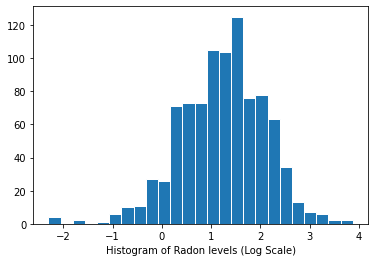

In [ ]:
plt.hist(log_radon.numpy(), bins=25, edgecolor='white')
plt.xlabel("Histogram of Radon levels (Log Scale)")
plt.show()

## 4 Conventional Approaches

The two conventional alternatives to modeling radon exposure represent the two
extremes of the bias-variance tradeoff:

**Complete Pooling:**

Treat all counties the same, and estimate a single radon level.
$$y_i = \alpha + \beta x_i + \epsilon_i$$

**No Pooling:**

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$ where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house
variation, or variation among houses.

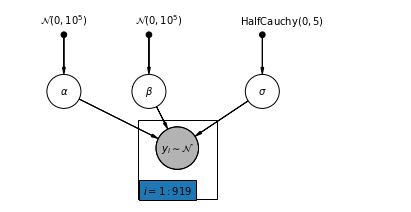

In [ ]:
#@title 4.1 Complete Pooling Model
pgm = daft.PGM([7, 3.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "alpha_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1,
        3,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "beta_prior",
        r"$\mathcal{N}(0, 10^5)$",
        2.5,
        3,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        4.5,
        3,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 2.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 4.5, 2))
pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 3, 1, scale=1.25, observed=True))
pgm.add_edge("alpha_prior", "alpha")
pgm.add_edge("beta_prior", "beta")
pgm.add_edge("sigma_prior", "sigma")
pgm.add_edge("sigma", "y_i")
pgm.add_edge("alpha", "y_i")
pgm.add_edge("beta", "y_i")
pgm.add_plate(daft.Plate([2.3, 0.1, 1.4, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

Below, we fit the complete pooling model using Hamiltonian Monte Carlo.

In [ ]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
  """`kernel_diag * x + bias` with broadcasting."""
  kernel_diag = tf.ones_like(x) * kernel_diag
  bias = tf.ones_like(x) * bias
  return x * kernel_diag + bias

In [ ]:
def pooled_model(floor):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  # alpha
      tfd.Normal(loc=0., scale=1e5),  # beta
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, b1[..., tf.newaxis], b0[..., tf.newaxis]),
          scale_identity_multiplier=s)
  ])


@tf.function
def pooled_log_prob(alpha, beta, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return pooled_model(floor).log_prob([alpha, beta, sigma, log_radon])

In [ ]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
  """Samples from the pooled model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=pooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.005)

  initial_state = [
      tf.zeros([num_chains], name='init_alpha'),
      tf.zeros([num_chains], name='init_beta'),
      tf.ones([num_chains], name='init_sigma')
  ]

  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
PooledModel = collections.namedtuple('PooledModel', ['alpha', 'beta', 'sigma'])

samples, acceptance_probs = sample_pooled(
    num_chains=4,
    num_results=1000,
    num_burnin_steps=1000,
    num_observations=num_observations)

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

Acceptance Probabilities for each chain:  [0.997 0.99  0.997 0.995]


In [ ]:
for var, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  alpha :	 1.0046891
R-hat for  beta :	 1.0128309
R-hat for  sigma :	 1.0010641


In [ ]:
def reduce_samples(var_samples, reduce_fn):
  """Reduces across leading two dims using reduce_fn. """
  # Collapse the first two dimensions, typically (num_chains, num_samples), and
  # compute np.mean or np.std along the remaining axis.
  if isinstance(var_samples, tf.Tensor):
    var_samples = var_samples.numpy() # convert to numpy array
  var_samples = np.reshape(var_samples, (-1,) +  var_samples.shape[2:])
  return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)

sample_mean = lambda samples : reduce_samples(samples, np.mean)

Plot the point estimates of the slope and intercept for the complete pooling
model.

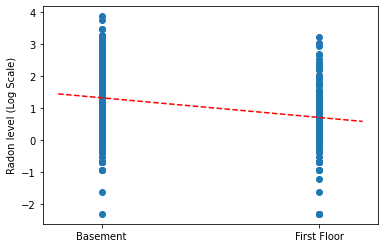

In [ ]:
LinearEstimates = collections.namedtuple('LinearEstimates',
                                        ['intercept', 'slope'])

pooled_estimate = LinearEstimates(
  intercept=sample_mean(pooled_samples.alpha),
  slope=sample_mean(pooled_samples.beta)
)

plt.scatter(radon.floor, radon.log_radon)
xvals = np.linspace(-0.2, 1.2)
plt.ylabel('Radon level (Log Scale)')
plt.xticks([0, 1], ['Basement', 'First Floor'])
plt.plot(xvals, pooled_estimate.intercept + pooled_estimate.slope * xvals, 'r--')
plt.show()

In [ ]:
#@title Utility function to plot traces of sampled variables.
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

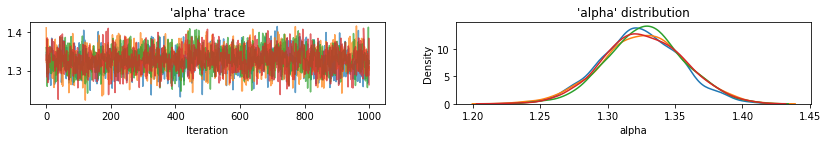

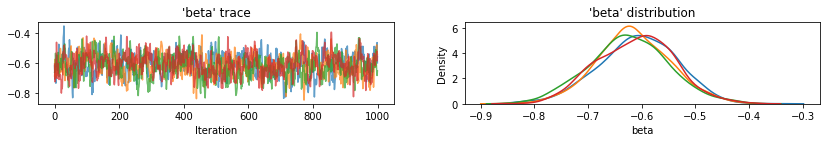

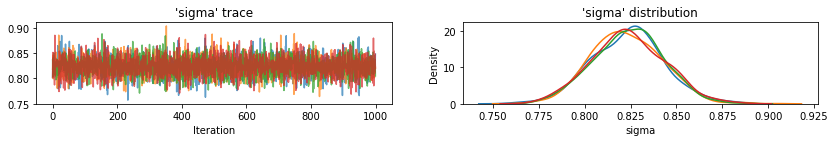

In [ ]:
for var, var_samples in pooled_samples._asdict().items():
  plot_traces(var, samples=var_samples, num_chains=4)


Next, we estimate the radon levels for each county in the unpooled model.

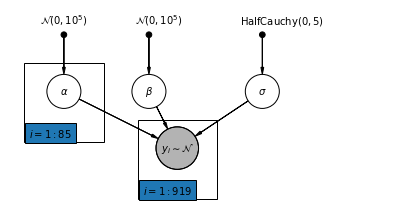

In [ ]:
#@title 4.2 Unpooled Model { display-mode: "form" }
pgm = daft.PGM([7, 3.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "alpha_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1,
        3,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "beta_prior",
        r"$\mathcal{N}(0, 10^5)$",
        2.5,
        3,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        4.5,
        3,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 2.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 4.5, 2))
pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 3, 1, scale=1.25, observed=True))
pgm.add_edge("alpha_prior", "alpha")
pgm.add_edge("beta_prior", "beta")
pgm.add_edge("sigma_prior", "sigma")
pgm.add_edge("sigma", "y_i")
pgm.add_edge("alpha", "y_i")
pgm.add_edge("beta", "y_i")
pgm.add_plate(daft.Plate([0.3, 1.1, 1.4, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([2.3, 0.1, 1.4, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def unpooled_model(floor, county):
  """Creates a joint distribution for the unpooled model."""
  return tfd.JointDistributionSequential([
      tfd.MultivariateNormalDiag(       # alpha
          loc=tf.zeros([num_counties]), scale_identity_multiplier=1e5),
      tfd.Normal(loc=0., scale=1e5),    # beta
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(
            floor, b1[..., tf.newaxis], tf.gather(b0, county, axis=-1)),
          scale_identity_multiplier=s)
  ])


@tf.function
def unpooled_log_prob(beta0, beta1, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return (
    unpooled_model(floor, county).log_prob([beta0, beta1, sigma, log_radon]))

In [ ]:
@tf.function
def sample_unpooled(num_chains, num_results, num_burnin_steps):
  """Samples from the unpooled model."""
  # Initialize the HMC transition kernel.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unpooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.025)

  initial_state = [
      tf.zeros([num_chains, num_counties], name='init_beta0'),
      tf.zeros([num_chains], name='init_beta1'),
      tf.ones([num_chains], name='init_sigma')
  ]
  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
UnpooledModel = collections.namedtuple('UnpooledModel',
                                       ['alpha', 'beta', 'sigma'])

samples, acceptance_probs = sample_unpooled(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
unpooled_samples = UnpooledModel._make(samples)

print('R-hat for beta:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.beta).numpy())
print('R-hat for sigma:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.sigma).numpy())

Acceptance Probabilities:  [0.892 0.897 0.911 0.91 ]
R-hat for beta: 1.0079623
R-hat for sigma: 1.0059084


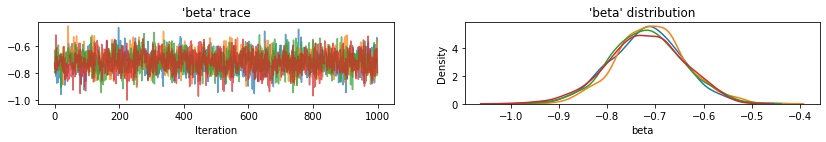

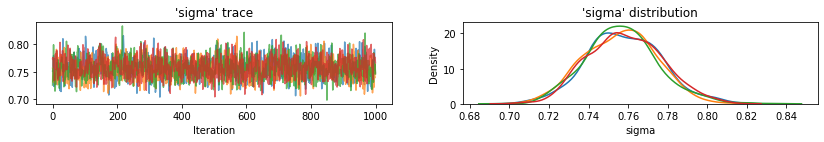

In [ ]:
plot_traces(var_name='beta', samples=unpooled_samples.beta, num_chains=4)
plot_traces(var_name='sigma', samples=unpooled_samples.sigma, num_chains=4)

Here are the unpooled county expected values for the intercept along with with
95% credible intervals for each chain. We also report R-hat value for each
county's estimate.

In [ ]:
#@title Utility function for Forest plots.
def forest_plot(num_chains, num_vars, var_name, var_labels, samples):
  fig, axes = plt.subplots(
      1, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
  for var_idx in range(num_vars):
    values = samples[..., var_idx]
    rhat = tfp.mcmc.diagnostic.potential_scale_reduction(values).numpy()
    meds = np.median(values, axis=-2)
    los = np.percentile(values, 5, axis=-2)
    his = np.percentile(values, 95, axis=-2)

    for i in range(num_chains):
      height = 0.1 + 0.3 * var_idx + 0.05 * i
      axes[0].plot([los[i], his[i]], [height, height], 'C0-', lw=2, alpha=0.5)
      axes[0].plot([meds[i]], [height], 'C0o', ms=1.5)
    axes[1].plot([rhat], [height], 'C0o', ms=4)

  axes[0].set_yticks(np.linspace(0.2, 0.3, num_vars))
  axes[0].set_ylim(0, 26)
  axes[0].grid(which='both')
  axes[0].invert_yaxis()
  axes[0].set_yticklabels(var_labels)
  axes[0].xaxis.set_label_position('top')
  axes[0].set(xlabel='95% Credible Intervals for {}'.format(var_name))

  axes[1].set_xticks([1, 2])
  axes[1].set_xlim(0.95, 2.05)
  axes[1].grid(which='both')
  axes[1].set(xlabel='R-hat')
  axes[1].xaxis.set_label_position('top')

  plt.show()

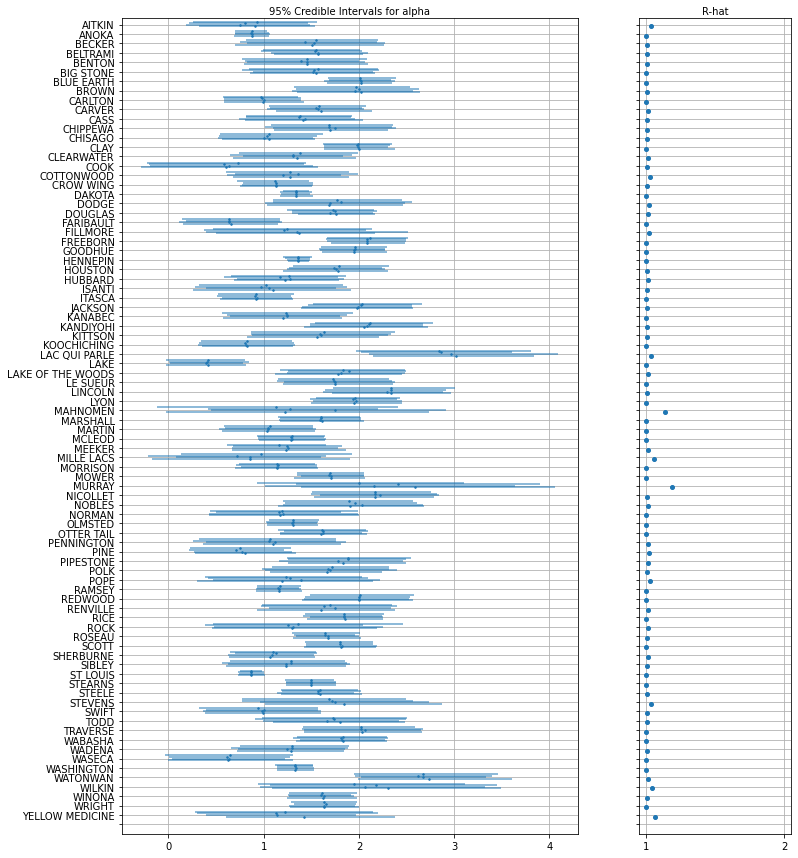

In [ ]:
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='alpha',
    var_labels=county_name,
    samples=unpooled_samples.alpha.numpy())

We can plot the ordered estimates to identify counties with high radon levels:

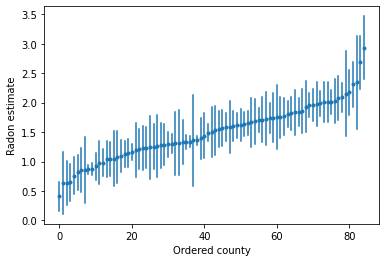

In [ ]:
unpooled_intercepts = reduce_samples(unpooled_samples.alpha, np.mean)
unpooled_intercepts_se = reduce_samples(unpooled_samples.alpha, np.std)

def plot_ordered_estimates():
  means = pd.Series(unpooled_intercepts, index=county_name)
  std_errors = pd.Series(unpooled_intercepts_se, index=county_name)
  order = means.sort_values().index

  plt.plot(range(num_counties), means[order], '.')
  for i, m, se in zip(range(num_counties), means[order], std_errors[order]):
    plt.plot([i, i], [m - se, m + se], 'C0-')
  plt.xlabel('Ordered county')
  plt.ylabel('Radon estimate')
  plt.show()

plot_ordered_estimates()

In [ ]:
#@title Utility function to plot estimates for a sample set of counties.
def plot_estimates(linear_estimates, labels, sample_counties):
  fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
  axes = axes.ravel()
  intercepts_indexed = []
  slopes_indexed = []
  for intercepts, slopes in linear_estimates:
    intercepts_indexed.append(pd.Series(intercepts, index=county_name))
    slopes_indexed.append(pd.Series(slopes, index=county_name))

  markers = ['-', 'r--', 'k:']
  sample_county_codes = [county_name.index(c) for c in sample_counties]
  for i, c in enumerate(sample_county_codes):
    y = radon.log_radon[radon.county == c]
    x = radon.floor[radon.county == c]
    axes[i].scatter(
        x + np.random.randn(len(x)) * 0.01, y, alpha=0.4, label='Log Radon')

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    for k in range(len(intercepts_indexed)):
      axes[i].plot(
          xvals,
          intercepts_indexed[k][c] + slopes_indexed[k][c] * xvals,
          markers[k],
          label=labels[k])

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Basement', 'First Floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(sample_counties[i])
    if not i % 2:
      axes[i].set_ylabel('Log Radon level')
  axes[3].legend(bbox_to_anchor=(1.05, 0.9), borderaxespad=0.)

  plt.show()

Here are visual comparisons between the pooled and unpooled estimates for a
subset of counties representing a range of sample sizes.

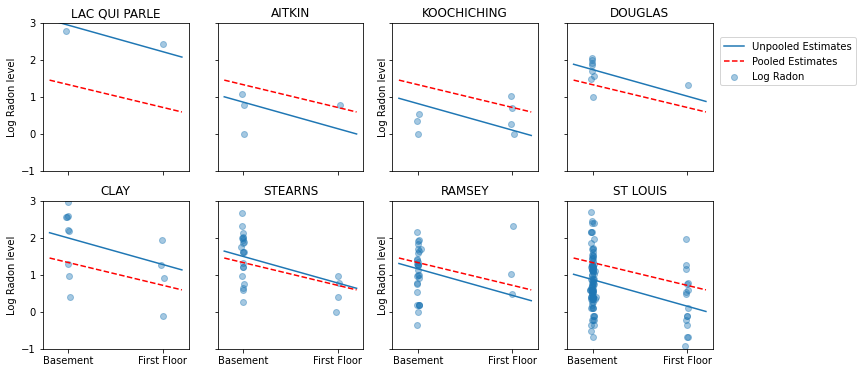

In [ ]:
unpooled_estimates = LinearEstimates(
  sample_mean(unpooled_samples.alpha),
  sample_mean(unpooled_samples.beta)
)

sample_counties = ('Lac Qui Parle', 'Aitkin', 'Koochiching', 'Douglas', 'Clay',
                   'Stearns', 'Ramsey', 'St Louis')
plot_estimates(
    linear_estimates=[unpooled_estimates, pooled_estimate],
    labels=['Unpooled Estimates', 'Pooled Estimates'],
    sample_counties=sample_counties)

Neither of these models are satisfactory:

*   if we are trying to identify high-radon counties, pooling is not useful.
*   we do not trust extreme unpooled estimates produced by models using few
    observations.

## 5 Multilevel and Hierarchical models

When we pool our data, we lose the information that different data points came from different counties. This means that each `radon`-level observation is sampled from the same probability distribution. Such a model fails to learn any
variation in the sampling unit that is inherent within a group (e.g. a county).
It only accounts for sampling variance.

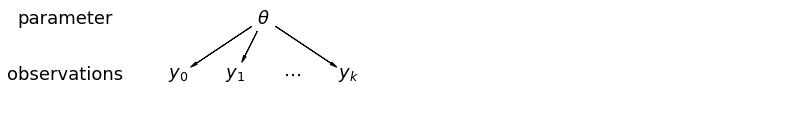

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=18)

pgm = daft.PGM([13.6, 2.2], origin=[1.15, 1.0], node_ec="none")
pgm.add_node(daft.Node("parameter", r"parameter", 2.0, 3))
pgm.add_node(daft.Node("observations", r"observations", 2.0, 2))
pgm.add_node(daft.Node("theta", r"$\theta$", 5.5, 3))
pgm.add_node(daft.Node("y_0", r"$y_0$", 4, 2))
pgm.add_node(daft.Node("y_1", r"$y_1$", 5, 2))
pgm.add_node(daft.Node("dots", r"$\cdots$", 6, 2))
pgm.add_node(daft.Node("y_k", r"$y_k$", 7, 2))
pgm.add_edge("theta", "y_0")
pgm.add_edge("theta", "y_1")
pgm.add_edge("theta", "y_k")
pgm.render()
plt.show()

When we analyze data unpooled, we imply that they are sampled independently from
separate models. At the opposite extreme from the pooled case, this approach
claims that differences between sampling units are too large to combine them:

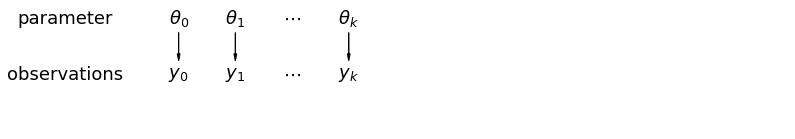

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=18)

pgm = daft.PGM([13.6, 2.2], origin=[1.15, 1.0], node_ec="none")
pgm.add_node(daft.Node("parameter", r"parameter", 2.0, 3))
pgm.add_node(daft.Node("observations", r"observations", 2.0, 2))
pgm.add_node(daft.Node("theta_0", r"$\theta_0$", 4, 3))
pgm.add_node(daft.Node("theta_1", r"$\theta_1$", 5, 3))
pgm.add_node(daft.Node("theta_dots", r"$\cdots$", 6, 3))
pgm.add_node(daft.Node("theta_k", r"$\theta_k$", 7, 3))

pgm.add_node(daft.Node("y_0", r"$y_0$", 4, 2))
pgm.add_node(daft.Node("y_1", r"$y_1$", 5, 2))
pgm.add_node(daft.Node("y_dots", r"$\cdots$", 6, 2))
pgm.add_node(daft.Node("y_k", r"$y_k$", 7, 2))
pgm.add_edge("theta_0", "y_0")
pgm.add_edge("theta_1", "y_1")
pgm.add_edge("theta_k", "y_k")
pgm.render()
plt.show()

In a hierarchical model, parameters are viewed as a sample from a population
distribution of parameters. Thus, we view them as being neither entirely
different or exactly the same. This is known as **partial pooling**.

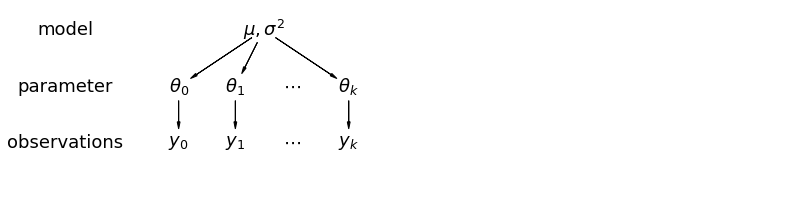

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=18)

pgm = daft.PGM([13.6, 3.4], origin=[1.15, 1.0], node_ec="none")
pgm.add_node(daft.Node("model", r"model", 2.0, 4))
pgm.add_node(daft.Node("parameter", r"parameter", 2.0, 3))
pgm.add_node(daft.Node("observations", r"observations", 2.0, 2))
pgm.add_node(daft.Node("mu_sigma", r"$\mu,\sigma^2$", 5.5, 4))
pgm.add_node(daft.Node("theta_0", r"$\theta_0$", 4, 3))
pgm.add_node(daft.Node("theta_1", r"$\theta_1$", 5, 3))
pgm.add_node(daft.Node("theta_dots", r"$\cdots$", 6, 3))
pgm.add_node(daft.Node("theta_k", r"$\theta_k$", 7, 3))
pgm.add_node(daft.Node("y_0", r"$y_0$", 4, 2))
pgm.add_node(daft.Node("y_1", r"$y_1$", 5, 2))
pgm.add_node(daft.Node("y_dots", r"$\cdots$", 6, 2))
pgm.add_node(daft.Node("y_k", r"$y_k$", 7, 2))
pgm.add_edge("mu_sigma", "theta_0")
pgm.add_edge("mu_sigma", "theta_1")
pgm.add_edge("mu_sigma", "theta_k")
pgm.add_edge("theta_0", "y_0")
pgm.add_edge("theta_1", "y_1")
pgm.add_edge("theta_k", "y_k")
pgm.render()
plt.show()

### 5.1 Partial Pooling

The simplest partial pooling model for the household radon dataset is one which
simply estimates radon levels, without any predictors at either the group or 
individual level. An example of a individual-level predictor is whether the 
data point is from the basement or the first floor. A group-level predictor can be the county-wide mean uranium levels. 

A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates. 

Let $\hat{\alpha}_j$ be the estimated log-radon level in county $j$. It's just an intercept; we ignore slopes for now. $n_j$ is the number of observations from county $j$. $\sigma_{\alpha}$ and $\sigma_y$ are the variance within the parameter and the sampling variance respectively. Then a partial pooling model could posit:

$$\hat{\alpha}_j \approx \frac{(n_j/\sigma_y^2)\bar{y}_j +
(1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

We expect the following when using partial pooling:
 * Estimates for counties with smaller sample sizes will shrink towards the
state-wide average.
 * Estimates for counties with larger sample sizes will be closer to the
unpooled county estimates.

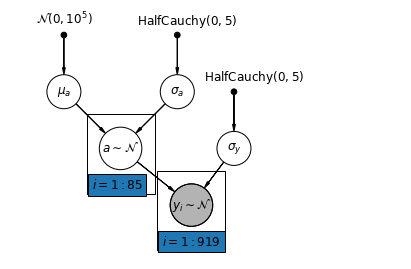

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=12)
pgm = daft.PGM([7, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "mu_a_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "sigma_a_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        3,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        4,
        3,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("mu_a", r"$\mu_a$", 1, 3))
pgm.add_node(daft.Node("sigma_a", r"$\sigma_a$", 3, 3))
pgm.add_node(daft.Node("a", r"$a \sim \mathcal{N}$", 2, 2, scale=1.25))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 4, 2))
pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 3.25, 1, scale=1.25, observed=True))
pgm.add_edge("mu_a_prior", "mu_a")
pgm.add_edge("sigma_a_prior", "sigma_a")
pgm.add_edge("mu_a", "a")
pgm.add_edge("sigma_a", "a")
pgm.add_edge("sigma_prior", "sigma_y")
pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_plate(daft.Plate([1.4, 1.2, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([2.65, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def partial_pooling_model(county):
  """Creates a joint distribution for the partial pooling model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=mu_a[..., tf.newaxis] * tf.ones([num_counties])[tf.newaxis, ...],
          scale_identity_multiplier=sigma_a),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, a: tfd.MultivariateNormalDiag(  # y
          loc=tf.gather(a, county, axis=-1),
          scale_identity_multiplier=sigma_y)
  ])


@tf.function
def partial_pooling_log_prob(mu_a, sigma_a, a, sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return partial_pooling_model(county).log_prob(
      [mu_a, sigma_a, a, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_partial_pooling(num_chains, num_results, num_burnin_steps):
  """Samples from the partial pooling model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=partial_pooling_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # a
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
PartialPoolingModel = collections.namedtuple(
    'PartialPoolingModel', ['mu_a', 'sigma_a', 'a', 'sigma_y'])

samples, acceptance_probs = sample_partial_pooling(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
partial_pooling_samples = PartialPoolingModel._make(samples)


Acceptance Probabilities:  [0.989 0.977 0.988 0.985]


In [ ]:
for var in ['mu_a', 'sigma_a', 'sigma_y']:
  print(
      'R-hat for ', var, '\t:',
      tfp.mcmc.potential_scale_reduction(getattr(partial_pooling_samples,
                                                 var)).numpy())

R-hat for  mu_a 	: 1.0216417
R-hat for  sigma_a 	: 1.0224565
R-hat for  sigma_y 	: 1.0016255


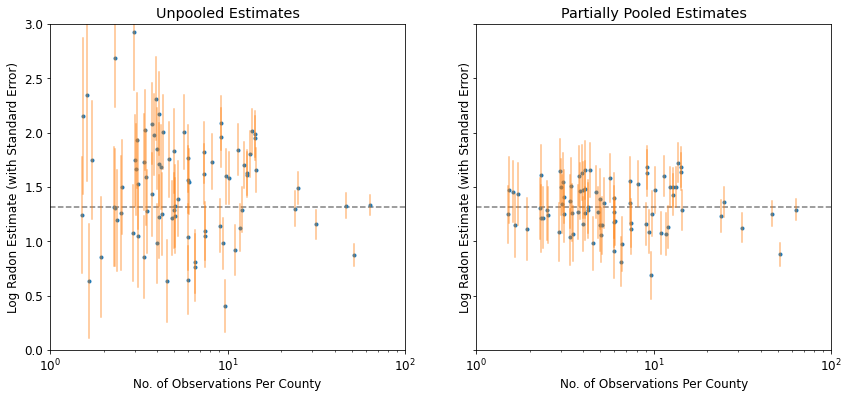

In [ ]:
partial_pooling_intercepts = reduce_samples(
    partial_pooling_samples.a.numpy(), np.mean)
partial_pooling_intercepts_se = reduce_samples(
    partial_pooling_samples.a.numpy(), np.std)

def plot_unpooled_vs_partial_pooling_estimates():
  fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

  # Order counties by number of observations (and add some jitter).
  num_obs_per_county = (
      radon.groupby('county')['idnum'].count().values.astype(np.float32))
  num_obs_per_county += np.random.normal(scale=0.5, size=num_counties)
  
  intercepts_list = [unpooled_intercepts, partial_pooling_intercepts]
  intercepts_se_list = [unpooled_intercepts_se, partial_pooling_intercepts_se]

  for ax, means, std_errors in zip(axes, intercepts_list, intercepts_se_list):
    ax.plot(num_obs_per_county, means, 'C0.')
    for n, m, se in zip(num_obs_per_county, means, std_errors):
      ax.plot([n, n], [m - se, m + se], 'C1-', alpha=.5)

  for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('No. of Observations Per County')
    ax.set_xlim(1, 100)
    ax.set_ylabel('Log Radon Estimate (with Standard Error)')
    ax.set_ylim(0, 3)
    ax.hlines(partial_pooling_intercepts.mean(), .9, 125, 'k', '--', alpha=.5)
  axes[0].set_title('Unpooled Estimates')
  axes[1].set_title('Partially Pooled Estimates')

plot_unpooled_vs_partial_pooling_estimates()

Notice the difference between the unpooled and partially-pooled estimates,
particularly at smaller sample sizes. The former are both more extreme and more
imprecise.

### 5.2 Varying Intercepts

We now a consider a more complex model that allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$ where 
$$\epsilon_i \sim N(0, \sigma_y^2)$$ and the intercept random effect: 
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$ 

The slope $\beta$, which lets the observation vary according to the location
of measurement (basement or first floor), is still a fixed effect shared between different counties.

As with the the unpooling model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling _shares strength_ among counties, allowing for more reasonable inference in counties with little data.

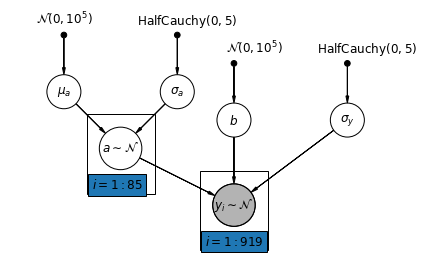

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=12)
pgm = daft.PGM([7, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "mu_a_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "sigma_a_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        3,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(
    daft.Node(
        "b_prior",
        r"$\mathcal{N}(0, 10^5)$",
        4,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("b", r"$b$", 4, 2.5))
pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        6,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("mu_a", r"$\mu_a$", 1, 3))
pgm.add_node(daft.Node("sigma_a", r"$\sigma_a$", 3, 3))
pgm.add_node(daft.Node("a", r"$a \sim \mathcal{N}$", 2, 2, scale=1.25))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 6, 2.5))
pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 4, 1, scale=1.25, observed=True))
pgm.add_edge("mu_a_prior", "mu_a")
pgm.add_edge("sigma_a_prior", "sigma_a")
pgm.add_edge("mu_a", "a")
pgm.add_edge("b_prior", "b")
pgm.add_edge("sigma_a", "a")
pgm.add_edge("sigma_prior", "sigma_y")
pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_edge("b", "y_i")
pgm.add_plate(daft.Plate([1.4, 1.2, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([3.4, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def varying_intercept_model(floor, county):
  """Creates a joint distribution for the varying intercept model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=affine(tf.ones([num_counties]), mu_a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_a),
      tfd.Normal(loc=0., scale=1e5),    # b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, b[..., tf.newaxis], tf.gather(a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


def varying_intercept_log_prob(mu_a, sigma_a, a, b, sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return varying_intercept_model(floor, county).log_prob(
      [mu_a, sigma_a, a, b, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_varying_intercepts(num_chains, num_results, num_burnin_steps):
  """Samples from the varying intercepts model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_intercept_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.zeros([num_chains], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
VaryingInterceptsModel = collections.namedtuple(
    'VaryingInterceptsModel', ['mu_a', 'sigma_a', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_intercepts(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_intercepts_samples = VaryingInterceptsModel._make(samples)

Acceptance Probabilities:  [0.978 0.987 0.982 0.984]


In [ ]:
for var in ['mu_a', 'sigma_a', 'b', 'sigma_y']:
  print(
      'R-hat for ', var, ': ',
      tfp.mcmc.potential_scale_reduction(
          getattr(varying_intercepts_samples, var)).numpy())

R-hat for  mu_a :  1.1099764
R-hat for  sigma_a :  1.1058794
R-hat for  b :  1.0448593
R-hat for  sigma_y :  1.0019052


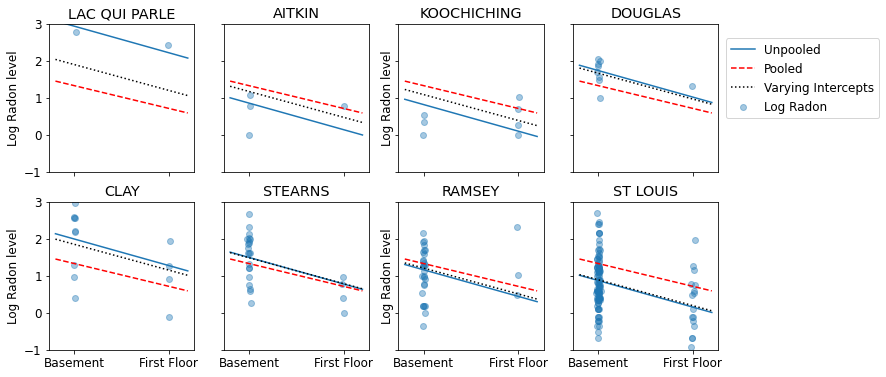

In [ ]:
varying_intercepts_estimates = LinearEstimates(
    sample_mean(varying_intercepts_samples.a),
    sample_mean(varying_intercepts_samples.b))
sample_counties = ('Lac Qui Parle', 'Aitkin', 'Koochiching', 'Douglas', 'Clay',
                   'Stearns', 'Ramsey', 'St Louis')
plot_estimates(
    linear_estimates=[
        unpooled_estimates, pooled_estimate, varying_intercepts_estimates
    ],
    labels=['Unpooled', 'Pooled', 'Varying Intercepts'],
    sample_counties=sample_counties)

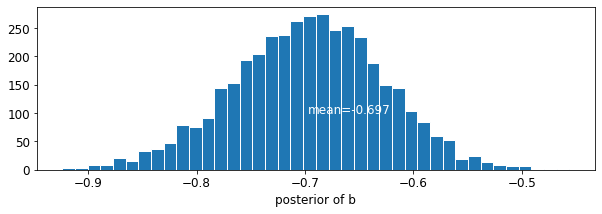

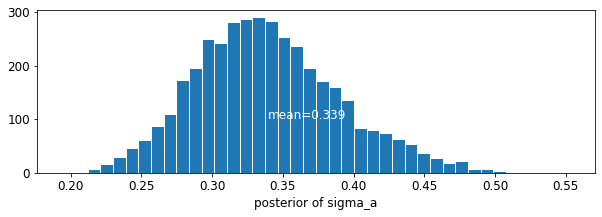

In [ ]:
def plot_posterior(var_name, var_samples):
  if isinstance(var_samples, tf.Tensor):
    var_samples = var_samples.numpy() # convert to numpy array

  fig = plt.figure(figsize=(10, 3))
  ax = fig.add_subplot(111)
  ax.hist(var_samples.flatten(), bins=40, edgecolor='white')
  sample_mean = var_samples.mean()
  ax.text(
      sample_mean,
      100,
      'mean={:.3f}'.format(sample_mean),
      color='white',
      fontsize=12)
  ax.set_xlabel('posterior of ' + var_name)
  plt.show()


plot_posterior('b', varying_intercepts_samples.b)
plot_posterior('sigma_a', varying_intercepts_samples.sigma_a)

The estimate for the floor coefficient is approximately -0.69, which can be
interpreted as houses without basements having about half ($\exp(-0.69) = 0.50$)
the radon levels of those with basements, after accounting for county.

In [ ]:
for var in ['b']:
  var_samples = getattr(varying_intercepts_samples, var)
  mean = var_samples.numpy().mean()
  std = var_samples.numpy().std()
  r_hat = tfp.mcmc.potential_scale_reduction(var_samples).numpy()
  n_eff = tfp.mcmc.effective_sample_size(var_samples).numpy().sum()

  print('var: ', var, ' mean: ', mean, ' std: ', std, ' n_eff: ', n_eff,
        ' r_hat: ', r_hat)

var:  b  mean:  -0.6972574  std:  0.06966117  n_eff:  397.94327  r_hat:  1.0448593


In [ ]:
def plot_intercepts_and_slopes(linear_estimates, title):
  xvals = np.arange(2)
  intercepts = np.ones([num_counties]) * linear_estimates.intercept
  slopes = np.ones([num_counties]) * linear_estimates.slope
  fig, ax = plt.subplots()
  for c in range(num_counties):
    ax.plot(xvals, intercepts[c] + slopes[c] * xvals, 'bo-', alpha=0.4)
  plt.xlim(-0.2, 1.2)
  ax.set_xticks([0, 1])
  ax.set_xticklabels(['Basement', 'First Floor'])
  ax.set_ylabel('Log Radon level')
  plt.title(title)
  plt.show()

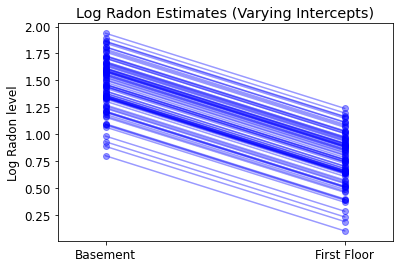

In [ ]:
plot_intercepts_and_slopes(varying_intercepts_estimates,
                           'Log Radon Estimates (Varying Intercepts)')

### 5.3 Varying Slopes

Alternatively, we can posit a model that allows the counties to vary according
to how the location of measurement (basement or first floor) influences the radon reading. In this case the intercept $\alpha$ is shared between counties.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

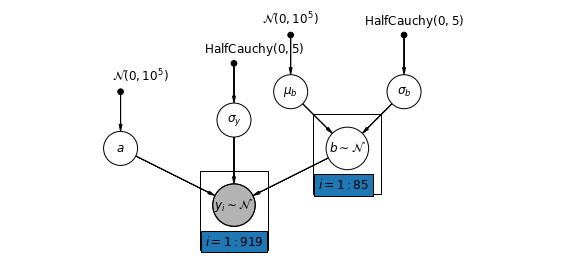

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=12)
pgm = daft.PGM([10, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "mu_b_prior",
        r"$\mathcal{N}(0, 10^5)$",
        3.2,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "a_prior", r"$\mathcal{N}(0, 10^5)$", 2, 3, fixed=True, offset=(20, 5)))
pgm.add_node(daft.Node("a", r"$a$", 2, 2))

pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        4,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 4, 2.5))

pgm.add_node(
    daft.Node(
        "mu_b_prior",
        r"$\mathcal{N}(0, 10^5)$",
        5,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "sigma_b_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        7,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(daft.Node("mu_b", r"$\mu_b$", 5, 3))
pgm.add_node(daft.Node("sigma_b", r"$\sigma_b$", 7, 3))
pgm.add_node(daft.Node("b", r"$b \sim \mathcal{N}$", 6, 2, scale=1.25))

pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 4, 1, scale=1.25, observed=True))
pgm.add_edge("a_prior", "a")

pgm.add_edge("mu_b_prior", "mu_b")
pgm.add_edge("sigma_b_prior", "sigma_b")
pgm.add_edge("mu_b", "b")
pgm.add_edge("sigma_b", "b")

pgm.add_edge("sigma_prior", "sigma_y")

pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_edge("b", "y_i")
pgm.add_plate(daft.Plate([5.4, 1.2, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([3.4, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def varying_slopes_model(floor, county):
  """Creates a joint distribution for the varying slopes model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  # mu_b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_b
      tfd.Normal(loc=0., scale=1e5),  # a
      lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(  # b
          loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
          scale_identity_multiplier=sigma_b),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, tf.gather(b, county, axis=-1), a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_y)
  ])


def varying_slopes_log_prob(mu_b, sigma_b, a, b, sigma_y):
  return varying_slopes_model(floor, county).log_prob(
      [mu_b, sigma_b, a, b, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_varying_slopes(num_chains, num_results, num_burnin_steps):
  """Samples from the varying slopes model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_slopes_log_prob,
      num_leapfrog_steps=25,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_b'),
      tf.ones([num_chains], name='init_sigma_b'),
      tf.zeros([num_chains], name='init_a'),
      tf.zeros([num_chains, num_counties], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_b
      tfb.Exp(),       # sigma_b
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
VaryingSlopesModel = collections.namedtuple(
    'VaryingSlopesModel', ['mu_b', 'sigma_b', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_slopes(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_slopes_samples = VaryingSlopesModel._make(samples)

Acceptance Probabilities:  [0.979 0.984 0.977 0.984]


In [ ]:
for var in ['mu_b', 'sigma_b', 'a', 'sigma_y']:
  print(
      'R-hat for ', var, '\t: ',
      tfp.mcmc.potential_scale_reduction(getattr(varying_slopes_samples,
                                                 var)).numpy())

R-hat for  mu_b 	:  1.0770341
R-hat for  sigma_b 	:  1.0634488
R-hat for  a 	:  1.0133665
R-hat for  sigma_y 	:  1.0011941


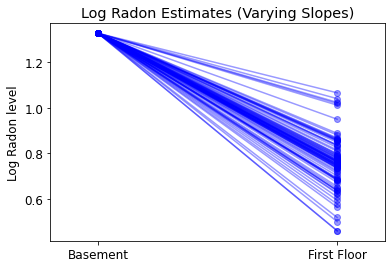

In [ ]:
varying_slopes_estimates = LinearEstimates(
    sample_mean(varying_slopes_samples.a),
    sample_mean(varying_slopes_samples.b))

plot_intercepts_and_slopes(varying_slopes_estimates,
                           'Log Radon Estimates (Varying Slopes)')

### 5.4 Varying Intercepts and Slopes

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

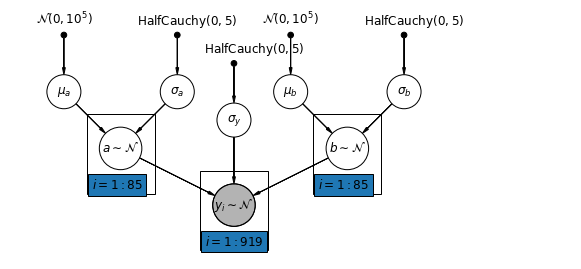

In [ ]:
#@title
mpl.rc("font", size=12)
pgm = daft.PGM([10, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "mu_a_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "sigma_a_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        3,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(daft.Node("mu_a", r"$\mu_a$", 1, 3))
pgm.add_node(daft.Node("sigma_a", r"$\sigma_a$", 3, 3))
pgm.add_node(daft.Node("a", r"$a \sim \mathcal{N}$", 2, 2, scale=1.25))

pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        4,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 4, 2.5))

pgm.add_node(
    daft.Node(
        "mu_b_prior",
        r"$\mathcal{N}(0, 10^5)$",
        5,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "sigma_b_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        7,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(daft.Node("mu_b", r"$\mu_b$", 5, 3))
pgm.add_node(daft.Node("sigma_b", r"$\sigma_b$", 7, 3))
pgm.add_node(daft.Node("b", r"$b \sim \mathcal{N}$", 6, 2, scale=1.25))

pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 4, 1, scale=1.25, observed=True))
pgm.add_edge("mu_a_prior", "mu_a")
pgm.add_edge("sigma_a_prior", "sigma_a")
pgm.add_edge("mu_a", "a")
pgm.add_edge("sigma_a", "a")

pgm.add_edge("mu_b_prior", "mu_b")
pgm.add_edge("sigma_b_prior", "sigma_b")
pgm.add_edge("mu_b", "b")
pgm.add_edge("sigma_b", "b")

pgm.add_edge("sigma_prior", "sigma_y")

pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_edge("b", "y_i")
pgm.add_plate(daft.Plate([1.4, 1.2, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([5.4, 1.2, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([3.4, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def varying_intercepts_and_slopes_model(floor, county):
  """Creates a joint distribution for the varying slope model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      tfd.Normal(loc=0., scale=1e5),    # mu_b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_b
      lambda sigma_b, mu_b, sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=affine(tf.ones([num_counties]), mu_a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_a),
      lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(  # b
          loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
          scale_identity_multiplier=sigma_b),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, tf.gather(b, county, axis=-1),
                     tf.gather(a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


@tf.function
def varying_intercepts_and_slopes_log_prob(mu_a, sigma_a, mu_b, sigma_b, a, b,
                                           sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return varying_intercepts_and_slopes_model(floor, county).log_prob(
      [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_varying_intercepts_and_slopes(num_chains, num_results,
                                         num_burnin_steps):
  """Samples from the varying intercepts and slopes model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_intercepts_and_slopes_log_prob,
      num_leapfrog_steps=50,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains], name='init_mu_b'),
      tf.ones([num_chains], name='init_sigma_b'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.zeros([num_chains, num_counties], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # mu_b
      tfb.Exp(),       # sigma_b
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
VaryingInterceptsAndSlopesModel = collections.namedtuple(
    'VaryingInterceptsAndSlopesModel',
    ['mu_a', 'sigma_a', 'mu_b', 'sigma_b', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_intercepts_and_slopes(
    num_chains=4, num_results=1000, num_burnin_steps=500)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_intercepts_and_slopes_samples = VaryingInterceptsAndSlopesModel._make(
    samples)

Acceptance Probabilities:  [0.988 0.985 0.992 0.938]


In [ ]:
for var in ['mu_a', 'sigma_a', 'mu_b', 'sigma_b']:
  print(
      'R-hat for ', var, '\t: ',
      tfp.mcmc.potential_scale_reduction(
          getattr(varying_intercepts_and_slopes_samples, var)).numpy())

R-hat for  mu_a 	:  1.010764
R-hat for  sigma_a 	:  1.0078123
R-hat for  mu_b 	:  1.0279609
R-hat for  sigma_b 	:  1.3165458


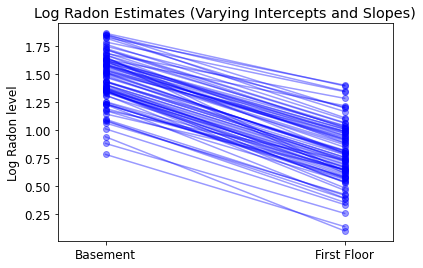

In [ ]:
varying_intercepts_and_slopes_estimates = LinearEstimates(
    sample_mean(varying_intercepts_and_slopes_samples.a),
    sample_mean(varying_intercepts_and_slopes_samples.b))

plot_intercepts_and_slopes(
    varying_intercepts_and_slopes_estimates,
    'Log Radon Estimates (Varying Intercepts and Slopes)')

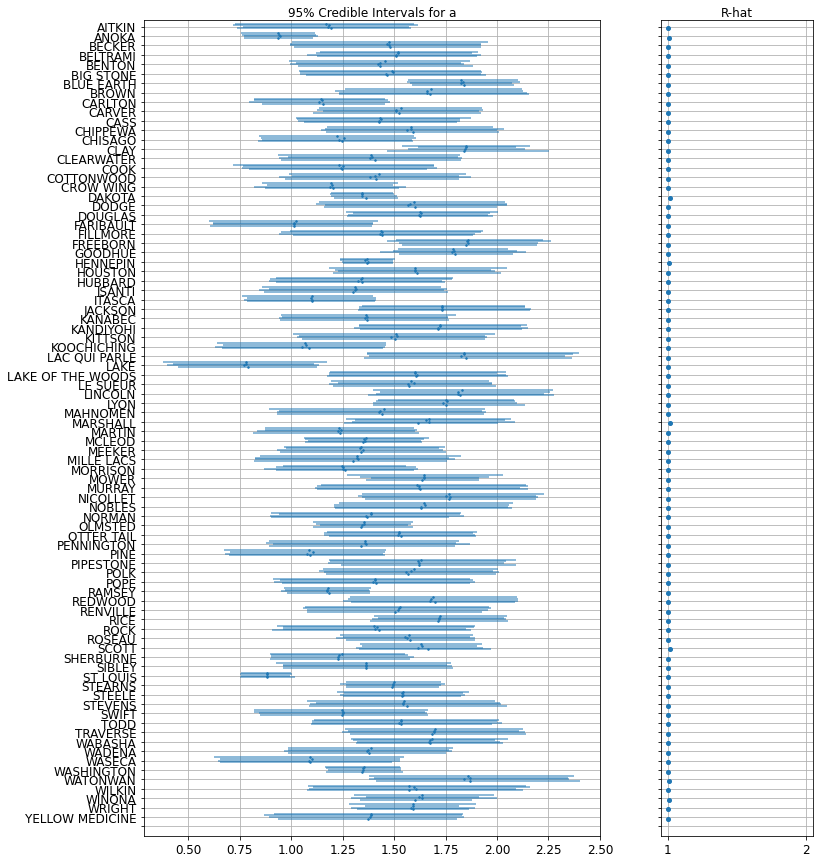

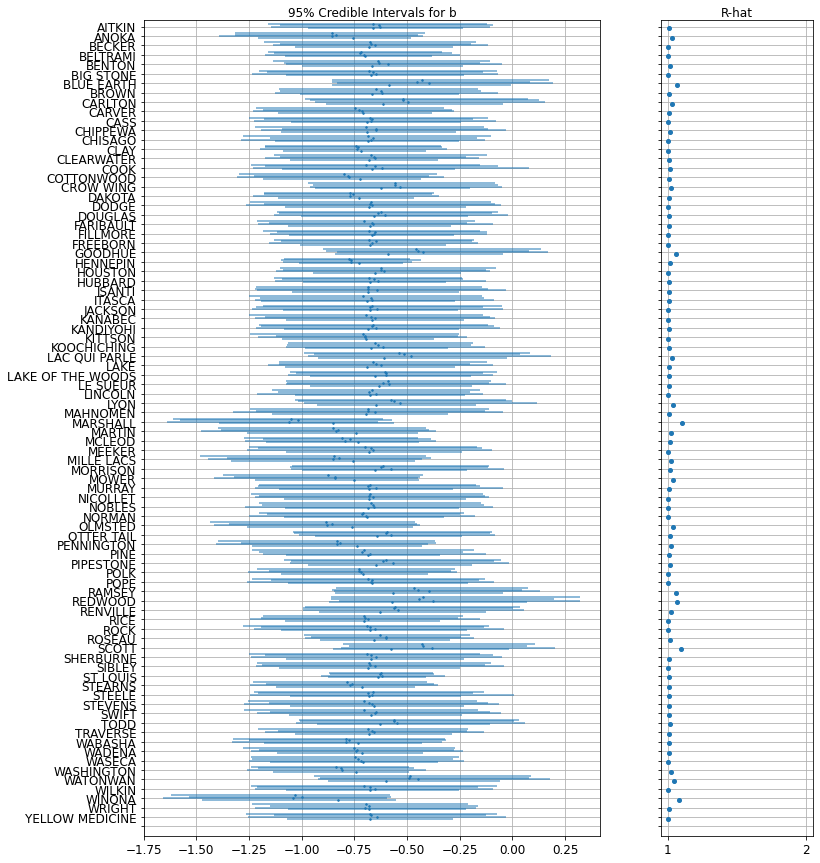

In [ ]:
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='a',
    var_labels=county_name,
    samples=varying_intercepts_and_slopes_samples.a.numpy())
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='b',
    var_labels=county_name,
    samples=varying_intercepts_and_slopes_samples.b.numpy())

## 6 Adding Group-level Predictors

A primary strength of multilevel models is the ability to handle predictors on
multiple levels simultaneously. If we consider the varying-intercepts model
above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$ we may, instead of a simple
random effect to describe variation in the expected radon value, specify another
regression model with a county-level covariate. Here, we use the county uranium
reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$$$\zeta_j \sim N(0,
\sigma_{\alpha}^2)$$ Thus, we are now incorporating a house-level predictor
(floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a
county-level covariate. In classical regression, this would result in
collinearity. In a multilevel model, the partial pooling of the intercepts
towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation
$\sigma_{\alpha}$. An important implication of this is that the group-level
estimate induces stronger pooling.

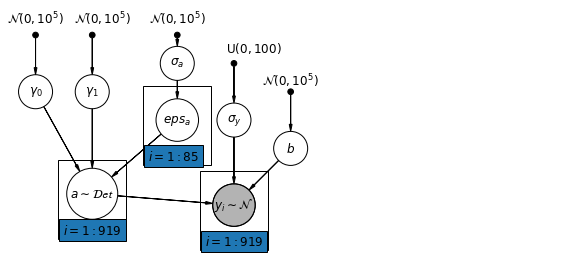

In [ ]:
#@title 6.1 Hierarchical Intercepts model { display-mode: "form" }
mpl.rc("font", size=12)
pgm = daft.PGM([10, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "gamma_0_prior",
        r"$\mathcal{N}(0, 10^5)$",
        0.5,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(
    daft.Node(
        "gamma_1_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1.5,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(daft.Node("gamma_0", r"$\gamma_0$", 0.5, 3))
pgm.add_node(daft.Node("gamma_1", r"$\gamma_1$", 1.5, 3))
pgm.add_node(
    daft.Node(
        "sigma_a_prior",
        r"$\mathcal{N}(0, 10^5)$",
        3,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(daft.Node("sigma_a", r"$\sigma_a$", 3, 3.5))
pgm.add_node(daft.Node("eps_a", r"$eps_a$", 3, 2.5, scale=1.25))
pgm.add_node(daft.Node("a", r"$a \sim \mathcal{Det}$", 1.5, 1.2, scale=1.5))

pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{U}(0, 100)$",
        4,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 4, 2.5))
pgm.add_node(daft.Node("b_prior", r"$\mathcal{N}(0, 10^5)$", 5, 3, fixed=True))
pgm.add_node(daft.Node("b", r"$b$", 5, 2))

pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 4, 1, scale=1.25, observed=True))

pgm.add_edge("gamma_0_prior", "gamma_0")
pgm.add_edge("gamma_1_prior", "gamma_1")
pgm.add_edge("sigma_a_prior", "sigma_a")
pgm.add_edge("sigma_a", "eps_a")
pgm.add_edge("gamma_0", "a")
pgm.add_edge("gamma_1", "a")
pgm.add_edge("eps_a", "a")

pgm.add_edge("b_prior", "b")
pgm.add_edge("sigma_prior", "sigma_y")

pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_edge("b", "y_i")
pgm.add_plate(daft.Plate([2.4, 1.7, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([0.9, 0.4, 1.2, 1.4], "$i = 1:919$"))
pgm.add_plate(daft.Plate([3.4, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
def hierarchical_intercepts_model(floor, county, log_uranium):
  """Creates a joint distribution for the varying slope model."""
  return tfd.JointDistributionSequential([
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a: tfd.MultivariateNormalDiag(  # eps_a
          loc=tf.zeros([num_counties]),
          scale_identity_multiplier=sigma_a),
      tfd.Normal(loc=0., scale=1e5),  # gamma_0
      tfd.Normal(loc=0., scale=1e5),  # gamma_1
      tfd.Normal(loc=0., scale=1e5),  # b
      tfd.Uniform(low=0., high=100),  # sigma_y
      lambda sigma_y, b, gamma_1, gamma_0, eps_a: tfd.
      MultivariateNormalDiag(  # y
          loc=affine(
              floor, b[..., tf.newaxis],
              affine(log_uranium, gamma_1[..., tf.newaxis], 
                     gamma_0[..., tf.newaxis]) + tf.gather(eps_a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


def hierarchical_intercepts_log_prob(sigma_a, eps_a, gamma_0, gamma_1, b,
                                     sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return hierarchical_intercepts_model(floor, county, log_uranium).log_prob(
      [sigma_a, eps_a, gamma_0, gamma_1, b, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_hierarchical_intercepts(num_chains, num_results, num_burnin_steps):
  """Samples from the hierarchical intercepts model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=hierarchical_intercepts_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='eps_a'),
      tf.zeros([num_chains], name='init_gamma_0'),
      tf.zeros([num_chains], name='init_gamma_1'),
      tf.zeros([num_chains], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # eps_a
      tfb.Identity(),  # gamma_0
      tfb.Identity(),  # gamma_0
      tfb.Identity(),  # b
      # Maps reals to [0, 100].
      tfb.Chain([tfb.Shift(shift=50.),
                 tfb.Scale(scale=50.),
                 tfb.Tanh()])  # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
HierarchicalInterceptsModel = collections.namedtuple(
    'HierarchicalInterceptsModel',
    ['sigma_a', 'eps_a', 'gamma_0', 'gamma_1', 'b', 'sigma_y'])

samples, acceptance_probs = sample_hierarchical_intercepts(
    num_chains=4, num_results=2000, num_burnin_steps=500)
print('Acceptance Probabilities: ', acceptance_probs.numpy())
hierarchical_intercepts_samples = HierarchicalInterceptsModel._make(samples)

Acceptance Probabilities:  [0.9615 0.941  0.955  0.95  ]


In [ ]:
for var in ['sigma_a', 'gamma_0', 'gamma_1', 'b', 'sigma_y']:
  print(
      'R-hat for', var, ':',
      tfp.mcmc.potential_scale_reduction(
          getattr(hierarchical_intercepts_samples, var)).numpy())

R-hat for sigma_a : 1.0469627
R-hat for gamma_0 : 1.0016835
R-hat for gamma_1 : 1.0097923
R-hat for b : 1.0014259
R-hat for sigma_y : 1.0025403


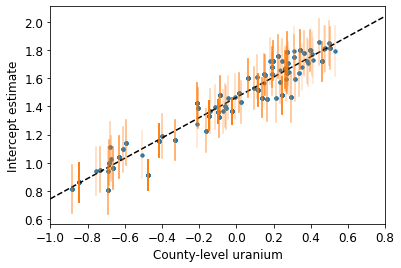

In [ ]:
def plot_hierarchical_intercepts():
  mean_and_var = lambda x : [reduce_samples(x, fn) for fn in [np.mean, np.var]]
  gamma_0_mean, gamma_0_var = mean_and_var(
    hierarchical_intercepts_samples.gamma_0)
  gamma_1_mean, gamma_1_var = mean_and_var(
    hierarchical_intercepts_samples.gamma_1)
  eps_a_means, eps_a_vars  = mean_and_var(hierarchical_intercepts_samples.eps_a)

  mu_a_means = gamma_0_mean + gamma_1_mean * log_uranium
  mu_a_vars = gamma_0_var + np.square(log_uranium) * gamma_1_var
  a_means = mu_a_means + eps_a_means[county]
  a_stds = np.sqrt(mu_a_vars + eps_a_vars[county])

  plt.figure()
  plt.scatter(log_uranium, a_means, marker='.', c='C0')
  xvals = np.linspace(-1, 0.8)
  plt.plot(xvals,gamma_0_mean + gamma_1_mean * xvals, 'k--')
  plt.xlim(-1, 0.8)

  for ui, m, se in zip(log_uranium, a_means, a_stds):
    plt.plot([ui, ui], [m - se, m + se], 'C1-', alpha=0.1)
  plt.xlabel('County-level uranium')
  plt.ylabel('Intercept estimate')


plot_hierarchical_intercepts()

The standard errors on the intercepts are narrower than for the partial-pooling
model without a county-level covariate.

### 6.2 Correlations Among Levels

In some instances, having predictors at multiple levels can reveal correlation
between individual-level variables and group residuals. We can account for this
by including the average of the individual predictors as a covariate in the
model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$ These are
broadly referred to as _contextual effects_.

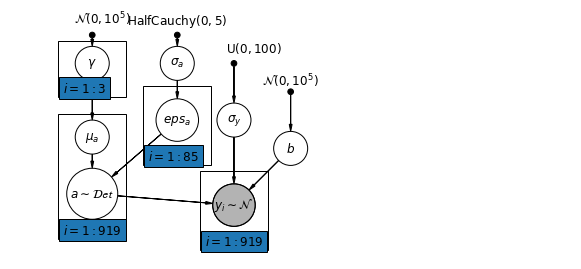

In [ ]:
#@title { display-mode: "form" }
mpl.rc("font", size=12)
pgm = daft.PGM([10, 4.5], node_unit=1.2)
pgm.add_node(
    daft.Node(
        "gamma_prior",
        r"$\mathcal{N}(0, 10^5)$",
        1.5,
        4,
        fixed=True,
        offset=(10, 5)))
pgm.add_node(daft.Node("gamma", r"$\gamma$", 1.5, 3.5))
pgm.add_node(daft.Node("mu_a", r"$\mu_a$", 1.5, 2.2))
pgm.add_node(
    daft.Node(
        "sigma_a_prior",
        r"$\mathrm{HalfCauchy}(0, 5)$",
        3,
        4,
        fixed=True,
        offset=(0, 5)))
pgm.add_node(daft.Node("sigma_a", r"$\sigma_a$", 3, 3.5))
pgm.add_node(daft.Node("eps_a", r"$eps_a$", 3, 2.5, scale=1.25))
pgm.add_node(daft.Node("a", r"$a \sim \mathcal{Det}$", 1.5, 1.2, scale=1.5))

pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{U}(0, 100)$",
        4,
        3.5,
        fixed=True,
        offset=(20, 5)))
pgm.add_node(daft.Node("sigma_y", r"$\sigma_y$", 4, 2.5))
pgm.add_node(daft.Node("b_prior", r"$\mathcal{N}(0, 10^5)$", 5, 3, fixed=True))
pgm.add_node(daft.Node("b", r"$b$", 5, 2))

pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 4, 1, scale=1.25, observed=True))

pgm.add_edge("gamma_prior", "gamma")
pgm.add_edge("sigma_a_prior", "sigma_a")
pgm.add_edge("sigma_a", "eps_a")
pgm.add_edge("gamma", "mu_a")
pgm.add_edge("mu_a", "a")
pgm.add_edge("eps_a", "a")

pgm.add_edge("b_prior", "b")
pgm.add_edge("sigma_prior", "sigma_y")

pgm.add_edge("sigma_y", "y_i")
pgm.add_edge("a", "y_i")
pgm.add_edge("b", "y_i")
pgm.add_plate(daft.Plate([0.9, 2.9, 1.2, 1.0], "$i = 1:3$"))
pgm.add_plate(daft.Plate([2.4, 1.7, 1.2, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([0.9, 0.4, 1.2, 2.2], "$i = 1:919$"))
pgm.add_plate(daft.Plate([3.4, 0.2, 1.2, 1.4], "$i = 1:919$"))

pgm.render()
plt.show()

In [ ]:
# Create a new variable for mean of floor across counties
xbar = tf.convert_to_tensor(radon.groupby('county')['floor'].mean(), tf.float32)
xbar = tf.gather(xbar, county, axis=-1)

In [ ]:
def contextual_effects_model(floor, county, log_uranium, xbar):
  """Creates a joint distribution for the varying slope model."""
  return tfd.JointDistributionSequential([
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a: tfd.MultivariateNormalDiag(  # eps_a
          loc=tf.zeros([num_counties]),
          scale_identity_multiplier=sigma_a),
      tfd.Normal(loc=0., scale=1e5),  # gamma_0
      tfd.Normal(loc=0., scale=1e5),  # gamma_1
      tfd.Normal(loc=0., scale=1e5),  # gamma_2
      tfd.Normal(loc=0., scale=1e5),  # b
      tfd.Uniform(low=0., high=100),  # sigma_y
      lambda sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: tfd.
      MultivariateNormalDiag(  # y
          loc=affine(
              floor, b[..., tf.newaxis],
              affine(log_uranium, gamma_1[..., tf.newaxis], gamma_0[
                  ..., tf.newaxis]) + affine(xbar, gamma_2[..., tf.newaxis]) +
              tf.gather(eps_a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


def contextual_effects_log_prob(sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b,
                                sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return contextual_effects_model(floor, county, log_uranium, xbar).log_prob(
      [sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b, sigma_y, log_radon])

In [ ]:
@tf.function
def sample_contextual_effects(num_chains, num_results, num_burnin_steps):
  """Samples from the hierarchical intercepts model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=contextual_effects_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='eps_a'),
      tf.zeros([num_chains], name='init_gamma_0'),
      tf.zeros([num_chains], name='init_gamma_1'),
      tf.zeros([num_chains], name='init_gamma_2'),
      tf.zeros([num_chains], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # eps_a
      tfb.Identity(),  # gamma_0
      tfb.Identity(),  # gamma_1
      tfb.Identity(),  # gamma_2
      tfb.Identity(),  # b
      tfb.Chain([tfb.Shift(shift=50.),
                 tfb.Scale(scale=50.),
                 tfb.Tanh()])  # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
ContextualEffectsModel = collections.namedtuple(
    'ContextualEffectsModel',
    ['sigma_a', 'eps_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y'])

samples, acceptance_probs = sample_contextual_effects(
    num_chains=4, num_results=2000, num_burnin_steps=500)
print('Acceptance Probabilities: ', acceptance_probs.numpy())
contextual_effects_samples = ContextualEffectsModel._make(samples)

Acceptance Probabilities:  [0.9505 0.9595 0.951  0.9535]


In [ ]:
for var in ['sigma_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y']:
  print(
      'R-hat for ', var, ': ',
      tfp.mcmc.potential_scale_reduction(
          getattr(contextual_effects_samples, var)).numpy())

R-hat for  sigma_a :  1.0709597
R-hat for  gamma_0 :  1.0067923
R-hat for  gamma_1 :  1.0089629
R-hat for  gamma_2 :  1.0054177
R-hat for  b :  1.0018929
R-hat for  sigma_y :  1.0032713


In [ ]:
for var in ['gamma_0', 'gamma_1', 'gamma_2']:
  var_samples = getattr(contextual_effects_samples, var)
  mean = var_samples.numpy().mean()
  std = var_samples.numpy().std()
  r_hat = tfp.mcmc.potential_scale_reduction(var_samples).numpy()
  n_eff = tfp.mcmc.effective_sample_size(var_samples).numpy().sum()

  print(var, ' mean: ', mean, ' std: ', std, ' n_eff: ', n_eff, ' r_hat: ',
        r_hat)

gamma_0  mean:  1.3934746  std:  0.04966602  n_eff:  816.21265  r_hat:  1.0067923
gamma_1  mean:  0.7229424  std:  0.088611916  n_eff:  1462.486  r_hat:  1.0089629
gamma_2  mean:  0.40893936  std:  0.20304097  n_eff:  457.8165  r_hat:  1.0054177


So, we might infer from this that counties with higher proportions of houses
without basements tend to have higher baseline levels of radon. Perhaps this is
related to the soil type, which in turn might influence what type of structures
are built.

### 6.3 Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the
unpooled, pooled, and partially-pooled models.

Root mean squared cross-validation prediction errors:

*   unpooled = 0.86
*   pooled = 0.84
*   multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1.  A new individual within an existing group
1.  A new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement
in St. Louis county, we just need to sample from the radon model with the
appropriate intercept.

In [ ]:
county_name.index('St Louis')

69

That is,

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

In [ ]:
st_louis_log_uranium = tf.convert_to_tensor(
    radon.where(radon['county'] == 69)['log_uranium_ppm'].mean(), tf.float32)
st_louis_xbar = tf.convert_to_tensor(
    radon.where(radon['county'] == 69)['floor'].mean(), tf.float32)

In [ ]:
@tf.function
def intercept_a(gamma_0, gamma_1, gamma_2, eps_a, log_uranium, xbar, county):
  return (affine(log_uranium, gamma_1, gamma_0) + affine(xbar, gamma_2) +
          tf.gather(eps_a, county, axis=-1))


def contextual_effects_predictive_model(floor, county, log_uranium, xbar,
                                        st_louis_log_uranium, st_louis_xbar):
  """Creates a joint distribution for the contextual effects model."""
  return tfd.JointDistributionSequential([
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a: tfd.MultivariateNormalDiag(  # eps_a
          loc=tf.zeros([num_counties]),
          scale_identity_multiplier=sigma_a),
      tfd.Normal(loc=0., scale=1e5),  # gamma_0
      tfd.Normal(loc=0., scale=1e5),  # gamma_1
      tfd.Normal(loc=0., scale=1e5),  # gamma_2
      tfd.Normal(loc=0., scale=1e5),  # b
      tfd.Uniform(low=0., high=100),  # sigma_y
      # y
      lambda sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: (
        tfd.MultivariateNormalDiag(
          loc=affine(
              floor, b[..., tf.newaxis],
              intercept_a(gamma_0[..., tf.newaxis], 
                          gamma_1[..., tf.newaxis], gamma_2[..., tf.newaxis],
                          eps_a, log_uranium, xbar, county)),
          scale_identity_multiplier=sigma_y)),
      # stl_pred
      lambda _, sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: tfd.Normal(
          loc=intercept_a(gamma_0, gamma_1, gamma_2, eps_a,
                          st_louis_log_uranium, st_louis_xbar, 69) + b,
          scale=sigma_y)
  ])


@tf.function
def contextual_effects_predictive_log_prob(sigma_a, eps_a, gamma_0, gamma_1,
                                           gamma_2, b, sigma_y, stl_pred):
  """Computes joint log prob pinned at `log_radon`."""
  return contextual_effects_predictive_model(floor, county, log_uranium, xbar,
                                             st_louis_log_uranium,
                                             st_louis_xbar).log_prob([
                                                 sigma_a, eps_a, gamma_0,
                                                 gamma_1, gamma_2, b, sigma_y,
                                                 log_radon, stl_pred
                                             ])

In [ ]:
@tf.function
def sample_contextual_effects_predictive(num_chains, num_results,
                                         num_burnin_steps):
  """Samples from the contextual effects predictive model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=contextual_effects_predictive_log_prob,
      num_leapfrog_steps=50,
      step_size=0.01)

  initial_state = [
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='eps_a'),
      tf.zeros([num_chains], name='init_gamma_0'),
      tf.zeros([num_chains], name='init_gamma_1'),
      tf.zeros([num_chains], name='init_gamma_2'),
      tf.zeros([num_chains], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y'),
      tf.zeros([num_chains], name='init_stl_pred')
  ]
  unconstraining_bijectors = [
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # eps_a
      tfb.Identity(),  # gamma_0
      tfb.Identity(),  # gamma_1
      tfb.Identity(),  # gamma_2
      tfb.Identity(),  # b
      tfb.Chain([tfb.Shift(shift=50.),
                 tfb.Scale(scale=50.),
                 tfb.Tanh()]),  # sigma_y
      tfb.Identity(),  # stl_pred
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [ ]:
ContextualEffectsPredictiveModel = collections.namedtuple(
    'ContextualEffectsPredictiveModel', [
        'sigma_a', 'eps_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y',
        'stl_pred'
    ])

samples, acceptance_probs = sample_contextual_effects_predictive(
    num_chains=4, num_results=2000, num_burnin_steps=500)
print('Acceptance Probabilities: ', acceptance_probs.numpy())
contextual_effects_pred_samples = ContextualEffectsPredictiveModel._make(
    samples)

Acceptance Probabilities:  [0.9165 0.978  0.9755 0.9785]


In [ ]:
for var in [
    'sigma_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y', 'stl_pred'
]:
  print(
      'R-hat for ', var, ': ',
      tfp.mcmc.potential_scale_reduction(
          getattr(contextual_effects_pred_samples, var)).numpy())

R-hat for  sigma_a :  1.0325582
R-hat for  gamma_0 :  1.0033548
R-hat for  gamma_1 :  1.0011047
R-hat for  gamma_2 :  1.001153
R-hat for  b :  1.0020066
R-hat for  sigma_y :  1.0128921
R-hat for  stl_pred :  1.0058256


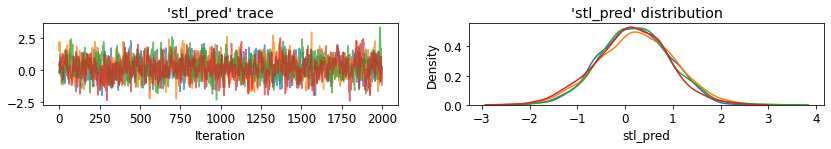

In [ ]:
plot_traces('stl_pred', contextual_effects_pred_samples.stl_pred, num_chains=4)

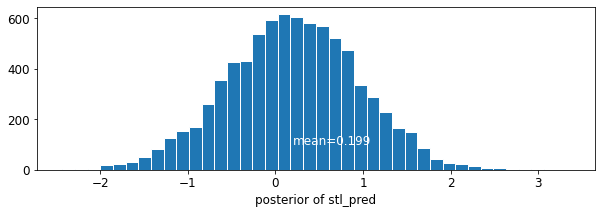

In [ ]:
plot_posterior('stl_pred', contextual_effects_pred_samples.stl_pred)

## 7 Conclusions

Benefits of Multilevel Models: 

  * Accounting for natural hierarchical structure of observational data.
  * Estimation of coefficients for (under-represented) groups.
  * Incorporating individual- and group-level information when estimating group-level coefficients.
  * Allowing for variation among individual-level coefficients across groups.

## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and
Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot
do. Technometrics, 48(3), 432–435.